In [1]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import wrf as wrfpy

#### Load in mmctools helper functions.
These are from the [a2e-mmc/mmctools repository](https://github.com/a2e-mmc/mmctools) (currently only in the dev branch). 

In [2]:
# manually add a2e-mmc repositories to PYTHONPATH if needed
#### If you have an 'a2e-mmc' directory under your $HOME
#module_path = os.path.join(os.environ['HOME'],'a2e-mmc')
#if module_path not in sys.path:
#    sys.path.append(module_path)
#### Alternatively, use a relative path to mmctools from this notebook 
####   (which lives in assessement/studies/perturbation_methods)
#### and assumes assessment and mmctools share some parent directory
sys.path.append('../../../')

In [3]:
from mmctools.helper_functions import calc_wind, theta, model4D_calcQOIs
from mmctools.wrf.utils import wrfout_seriesReader

# Example: Assessment of Mesoscale Domain Results
Model data is the convective case from perturbations method study

In [4]:
TTUdata = '../../datasets/SWiFT/data/TTU_tilt_corrected_20131108-09.csv'

In [5]:
modeldatapath = '/glade/scratch/jsauer/A2E-MMC/PMIC1/TEST_SANITY/'
#modeldatapath = '/scratch/equon/CBL_18Z-20Z'
model_file_filter = 'wrfout_d01_2013-11-08_[12][680]:00:00'
modelHours = [16,18,20]  #commensurate with model_file_filter

In [6]:
# where to save outputs (e.g., figures, assessment metrics,...)
outputdir = modeldatapath
modeloutputfile = 'CBL_meso_profiles_16Z-18Z'

## Load observation data
Load a processed TTU dataset for demonstration purposes. The dataset can be obtained by running the notebook `process_TTU_tower.ipynb` which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment/tree/dev) (currently only in the dev branch)

<font color='red'>TODO: use multiindex for datetime/height</font>

In [7]:
df = pd.read_csv(TTUdata, parse_dates=True, index_col='datetime')
df.head()

,height,u,v,w,t,ts,p
datetime,,,,,,,
2013-11-08,0.9,-0.138929,2.637817,0.074016,284.794,289.410000,908.547754
2013-11-08,2.4,-0.601111,2.783204,0.487330,284.932,290.979994,908.723508
2013-11-08,4.0,0.416792,4.043940,0.295800,285.166,287.520000,908.215548
2013-11-08,10.1,-0.276479,5.227110,-0.418065,285.298,287.250000,907.611414
2013-11-08,16.8,0.034364,5.908367,-0.173836,285.414,287.610000,907.307654


## Compute derived metrics (wspd, wdir, theta) from the observation data
Do some additional data processing to obtain windspeed, wind direction and potential temperature using helper functions. 

In [8]:
# Calculate wind speed and direction
df['wspd'], df['wdir'] = calc_wind(df)

# Calculate potential temperature
df['theta'] = theta(df['t'],df['p'])

df.head(n=10)

,height,u,v,w,t,ts,p,wspd,wdir,theta
datetime,,,,,,,,,,
2013-11-08,0.9,-0.138929,2.637817,0.074016,284.794,289.410000,908.547754,2.641473,176.985128,292.713920
2013-11-08,2.4,-0.601111,2.783204,0.487330,284.932,290.979994,908.723508,2.847378,167.812564,292.839558
2013-11-08,4.0,0.416792,4.043940,0.295800,285.166,287.520000,908.215548,4.065362,185.884463,293.126923
2013-11-08,10.1,-0.276479,5.227110,-0.418065,285.298,287.250000,907.611414,5.234417,176.972263,293.318423
2013-11-08,16.8,0.034364,5.908367,-0.173836,285.414,287.610000,907.307654,5.908467,180.333242,293.465778
2013-11-08,47.3,-0.299790,7.742319,-0.449776,285.698,290.000000,902.911430,7.748121,177.782562,294.166144
2013-11-08,74.7,-0.383357,9.024248,-0.042725,285.784,291.070000,900.655410,9.032387,177.567492,294.465306
2013-11-08,116.5,0.176337,9.460641,-0.050773,285.362,287.170000,896.267652,9.462284,181.067816,294.441453
2013-11-08,158.2,0.533686,9.701320,-0.329569,285.114,289.320000,892.083416,9.715988,183.148765,294.579540


## Calculate 30-minute rolling means
Use pandas intrinsics pivot, resample, stack to find the 30-minute means of the derived metrics for the SWiFT, TTU tower observations.

In [9]:
df30 = df.pivot(columns='height',values=['u','v','w','wspd','wdir','theta']).resample('30min').mean().stack()
df30.reset_index(inplace=True)
df30.set_index(['datetime'],inplace=True)

## Load mesoscale modeling results data 

In [10]:
obs_legStrs = []
mod_legStrs = []
datetimeStrs = []
for modelHour in modelHours:
    obs_legStrs.append('Obs-{:d}Z'.format(modelHour))
    mod_legStrs.append('Mod-{:d}Z'.format(modelHour))
    datetimeStrs.append('2013-11-08 {:2d}:00:00'.format(modelHour))
print(obs_legStrs)
print(mod_legStrs)
print(datetimeStrs)

['Obs-16Z', 'Obs-18Z', 'Obs-20Z']
['Mod-16Z', 'Mod-18Z', 'Mod-20Z']
['2013-11-08 16:00:00', '2013-11-08 18:00:00', '2013-11-08 20:00:00']


In [11]:
#%time ds = wrfout_seriesReader(modeldatapath,model_file_filter,specified_heights=df30['height'].unique())    
%time ds = wrfout_seriesReader(modeldatapath,model_file_filter)    

Finished opening/concatenating datasets...
Establishing coordinate variables, x,y,z, zSurface...
Destaggering data variables, u,v,w...
Extracting data variables, p,theta...
Calculating derived data variables, wspd, wdir...
CPU times: user 420 ms, sys: 54.4 ms, total: 475 ms
Wall time: 542 ms


In [12]:
%time ds=model4D_calcQOIs(ds,'ny')

CPU times: user 162 ms, sys: 16.9 ms, total: 179 ms
Wall time: 184 ms


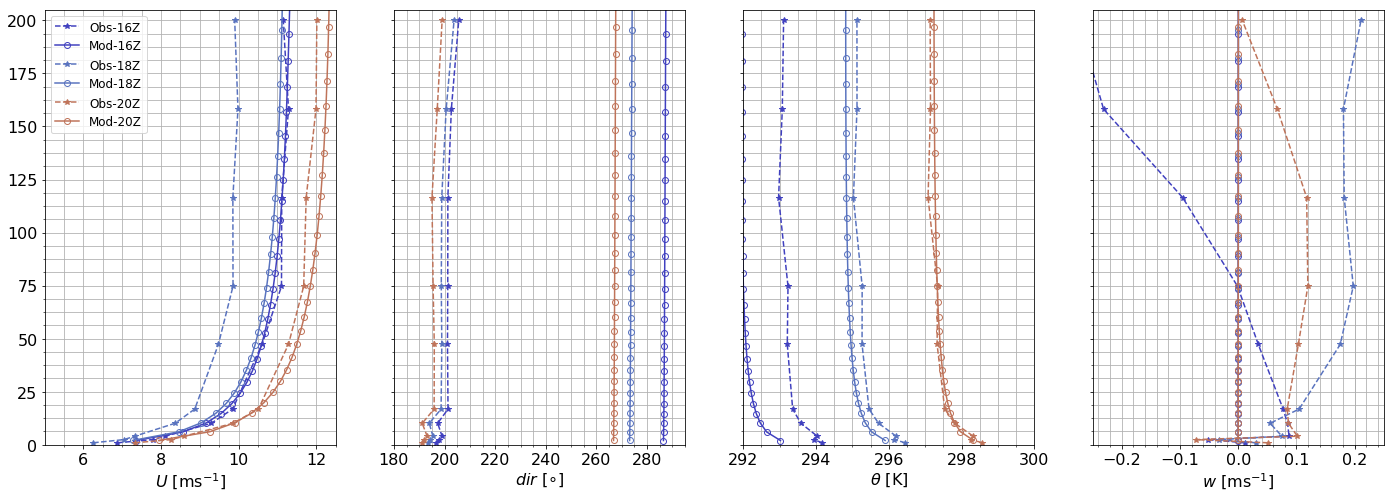

In [13]:
fntSize=16
plt.rcParams['xtick.labelsize']=fntSize
plt.rcParams['ytick.labelsize']=fntSize
numPlotsX = 1
numPlotsY = 4
colors = []
colors.append([0.25,0.25,0.75])
colors.append([0.35,0.45,0.75])
colors.append([0.75,0.45,0.35])
fig,ax = plt.subplots(numPlotsX,numPlotsY,sharey=True,sharex=False,figsize=(24,8))

# plot-windspeed
for it in range(len(modelHours)): 
    if 'datetime' in ds['z'].dims:
        zValues = ds['z'].sel(datetime=datetimeStrs[it]).mean(axis=(1,2))
    else:
        zValues = ds['z']
    # plot-windspeed
    im = ax[0].plot(df30['wspd'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
    im = ax[0].plot(ds['UMean'].sel(datetime=datetimeStrs[it]).mean(axis=1),
                    zValues,
                    'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
    # plot-wind_dir.
    im = ax[1].plot(df30['wdir'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
    im = ax[1].plot(ds['UdirMean'].sel(datetime=datetimeStrs[it]).mean(axis=1),
                    zValues,
                    'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
    # plot-theta
    im = ax[2].plot(df30['theta'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
    im = ax[2].plot(ds['thetaMean'].sel(datetime=datetimeStrs[it]).mean(axis=1),
                    zValues,
                    'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
    # plot-w
    im = ax[3].plot(df30['w'].loc[datetimeStrs[it]],df30['height'].loc[datetimeStrs[it]],'*--',color=colors[it],label=obs_legStrs[it])
    im = ax[3].plot(ds['wMean'].sel(datetime=datetimeStrs[it]).mean(axis=1),
                    zValues,
                    'o-',color=colors[it],markerfacecolor="None",label=mod_legStrs[it])
    
ax[0].set_ylim([0,205])
ax[0].set_xlim([5,12.5])
ax[1].set_xlim([180,295])
ax[2].set_xlim([292,300])
ax[3].set_xlim([-0.25,0.25])

ax[0].legend(fontsize=12)
ax[0].set_xlabel(r'$U$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
ax[0].minorticks_on()
ax[0].grid(which='both')

ax[1].set_xlabel(r'$dir$ $[\mathrm{\circ}]$',fontsize=fntSize)
ax[1].minorticks_on()
ax[1].grid(which='both')

ax[2].set_xlabel(r'$\theta$ $[\mathrm{K}]$',fontsize=fntSize)
ax[2].minorticks_on()
ax[2].grid(which='both')

ax[3].set_xlabel(r'$w$ $[\mathrm{ms^{-1}}]$',fontsize=fntSize)
ax[3].minorticks_on()
ax[3].grid(which='both')

<font color='red'>TODO: simplify this section with `mmctools.plotting.plot_profile` (update plotting library to handle xarray input)</font>

## Save mesoscale modeling results data and figure 

In [14]:
#Save the processed model output and share with others!
modelprocessedname = os.path.join(outputdir,modeloutputfile)   
print('Writing out',modelprocessedname)
ds.to_netcdf(modelprocessedname, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
figurefilename = os.path.join(outputdir, 'Profiles-PMIC1_d01_test.png')
print('Writing out',figurefilename)
fig.savefig(figurefilename, dpi=200, bbox_inches='tight')

Writing out /glade/scratch/jsauer/A2E-MMC/PMIC1/TEST_SANITY/CBL_meso_profiles_16Z-18Z
Writing out /glade/scratch/jsauer/A2E-MMC/PMIC1/TEST_SANITY/Profiles-PMIC1_d01_test.png
